# Agenda

---

60 min: Overview of Association tests used in GWAS, how and when they are used

We have already used example of the following:
* $\chi^2$ tests
* Odds Ratio

Now it is time to look at slightly more sopisticated approaches to analysis:

* Linear regression (continuous trait: height, blood pressure )
* Logistic Regression (binary trait: presence or absence of disease = case/controls)
* Multilinear regression
* Discussion of Covariates

## Goals

* Have a basic understanding of regression, association tests and one single p-value.
* Have a basic understanding of multiple hypothesis testing and dealing with >1 million p-values simultaneously.

## Dataset

We will use the dataset from [Statistical Learning of Large-Scale Genetic Data: How to Run a Genome-Wide Association Study of Gene-Expression Data Using the 1000 Genomes Project Data](https://pmc.ncbi.nlm.nih.gov/articles/PMC10940486/) by  Sugolov, Emmenegger, Paterson, & Sun (2023).

## Seaborn Resources

In this lesson, we will use the Seaborn data visualization library. Here are some helpful resources for Seaborn:

* [DataCamp Seaborn Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Seaborn_Cheat_Sheet.pdf)
* [Seaborn Tutorial](https://seaborn.pydata.org/tutorial/introduction.html)
* [Additional Seaborn Cheat Sheet](https://cheatography.com/arshdeep/cheat-sheets/seaborn/)

# Statistics of GWAS

---

The general regression equation:

$$Y∼α+βX+g+e$$

* Y phenotypic values
* X genotype variant
* $\beta$ is effect of the SNP on the outcome
* g∼N(0,$σ_A^2$)
    * g is some type of correction for relatedness etc (Often first two Principal components)
* e∼N(0,$σ_e^2$)
    * e is random error

You can see this plotted as:

![Regression](https://raw.githubusercontent.com/awnorowski/BDSiC_2025/refs/heads/main/images/regressionGWAS.png)




# PHENOTYPE GENOTYPE ASSOCIATION ANALYSIS

---

## Simple Linear Regression
Fundamental question for this data set: does the genotype of **SNP1-5618704** (X variable; independent variable) influence the expression of **ERAP2** (Y variable; dependent variable).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm

In [ ]:
# Step 1: bring data in - this data is conveniently online!
Ex1url="https://www.utstat.toronto.edu/sun/data/GWAS-workshop-sample-dataset-ERAP2.txt"
mydata_ERAP2=pd.read_csv(Ex1url,sep='\t')
print(mydata_ERAP2.head(8))
# we will not deal with PLINK, but this dataset holds the type of information that you will need when using PLINK

    FID      IID  PID  MID  SEX     PHENO  POP SNP1-5618704 SNP1-57815437  \
0  1328  NA06984    0    0    1  11.49810  CEU           AA            AA   
1  1328  NA06989    0    0    2  10.67960  CEU           AA            AA   
2  1330  NA12340    0    0    1  10.54530  CEU           AA            AA   
3  1330  NA12341    0    0    2  11.45550  CEU           AA            AA   
4  1330  NA12342    0    0    1   7.98708  CEU           AA            AA   
5  1330  NA12343    0    0    2  11.26740  CEU           AA            AA   
6  1334  NA12144    0    0    1  12.11140  CEU           AA            AA   
7  1334  NA12145    0    0    2  11.81990  CEU           AA            AA   

  SNP1-64302980  ... SNP18-46491800 SNP18-66700491 SNP19-2446724  \
0            CC  ...             GG             AA            GG   
1            CC  ...             GG             AA            AG   
2            TT  ...             GG             AA            GG   
3            TC  ...             G

### Data Wrangling

Now that we have brought the dataset in, we are going to do some data peeking and some wrangling.

This is where we will rely heavily on Pandas!

In [ ]:
# male = 1, female = 2 by convention
# CEU: Utah residents with Northern and Western European ancestry from the CEPH collection
# YRI: Yoruba in Ibadan, Nigeria


# Notice the difference between the following commands
print(mydata_ERAP2.groupby(["SEX","POP"]).count())
print("~~~~~~~~~~~~~~~~~~~~~")
print(mydata_ERAP2.groupby(["SEX","POP"])["PHENO"].mean())
#----------------------------------------------------
#print(mydata_ERAP2.describe())
print("~~~~~~~~~~~~~~~~~~~~~")
print(mydata_ERAP2["PHENO"].describe())

         FID  IID  PID  MID  PHENO  SNP1-5618704  SNP1-57815437  \
SEX POP                                                           
1   CEU   53   53   53   53     53            53             53   
    YRI   46   46   46   46     46            46             46   
2   CEU   51   51   51   51     51            51             51   
    YRI   45   45   45   45     45            45             45   

         SNP1-64302980  SNP1-104336159  SNP1-151435036  ...  SNP18-46491800  \
SEX POP                                                 ...                   
1   CEU             53              53              53  ...              53   
    YRI             46              46              46  ...              46   
2   CEU             51              51              51  ...              51   
    YRI             45              45              45  ...              45   

         SNP18-66700491  SNP19-2446724  SNP19-6387304  rs427366  \
SEX POP                                                

In [ ]:
# in order to make this tractable into a visualization, we need to do some recoding into dosages:
# We convert the AA into 0, AC/CA into 1 and CC into 2 representing the number of C alleles
# we are doing this via the map function and each C allele contributes 1 dose
# The following is a simple example where only one column, SNP1-5618704, is focused on.
# ----------
mydata_converted= mydata_ERAP2["SNP1-5618704"].map({'AA': 0, 'AC': 1, 'CA':1, 'CC': 2})
print(mydata_converted)

0      0
1      0
2      0
3      0
4      0
      ..
190    2
191    0
192    1
193    0
194    2
Name: SNP1-5618704, Length: 195, dtype: int64


In [ ]:
# So, now we will see a visualization of the phenotype-genotype association for CEU
# We are pulling out the CEU individuals and the two columns from the larger dataset
CEUCurated=mydata_ERAP2[mydata_ERAP2.POP=="CEU"][["PHENO","SNP1-5618704"]]
#print(CEUCurated.head())
print("~~~~~~~")
CEUNumConversion=CEUCurated["SNP1-5618704"].map({'AA': 0,'AC': 1,"CA":1,'CC': 2})
#print(CEUNumConversion.head())

CEUCon=pd.concat([CEUCurated["PHENO"],CEUNumConversion],axis=1)
print(CEUCon)
#print(type(CEUCon))

~~~~~~~
        PHENO  SNP1-5618704
0    11.49810             0
1    10.67960             0
2    10.54530             0
3    11.45550             0
4     7.98708             0
..        ...           ...
99   11.91800             0
100   8.11012             0
101  12.29190             0
102  11.55000             0
103  10.68810             0

[104 rows x 2 columns]


### Visualization: Simple Linear Regression

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


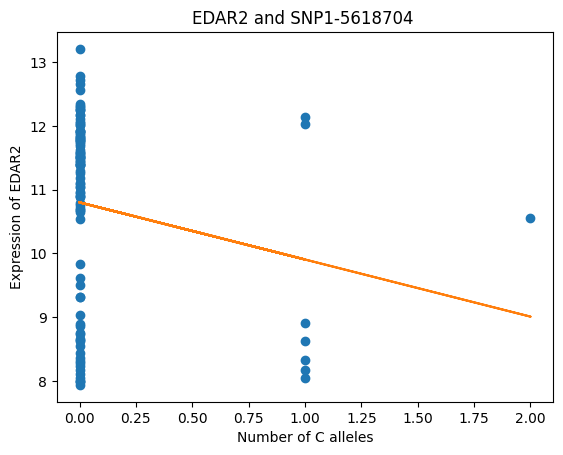

In [ ]:
# simple linear regression: average value of Y =intercept +slope*X
x=np.array(CEUNumConversion)
y=np.array(CEUCurated["PHENO"])
print(type(x))
print(type(y))

# there is a polyfit method in numpy that requires a degree=1 for linear, and different numbers for polynomials etc
b,m=np.polyfit(x,y,deg=1)

plt.plot(x,y,"o",label='scatter plot')
#plt.ylim([5,15])
plt.xlabel("Number of C alleles")
plt.ylabel("Expression of EDAR2")
plt.title("EDAR2 and SNP1-5618704 ")
plt.plot(x,m+b*x,"-")

__Important scientific question: Does the genotype of SNP1-5618704  (X) influence the gene expression of ERAP2 (Y)? Does Y depend on X?__

Descriptively it certainly seems promising. But we would need to conduct a statistical test to quantify if the regression line is significantly different from 0.


In [ ]:
# What is the slope and is it statistically different than 0?
print("the intercept is: ", m)
print("the slope is: ", b)
# We would have to use statistics to quantify how different from 0 this is, but it seems unlikely to be different.

the intercept is:  10.799663988711169
the slope is:  -0.8963905362182295


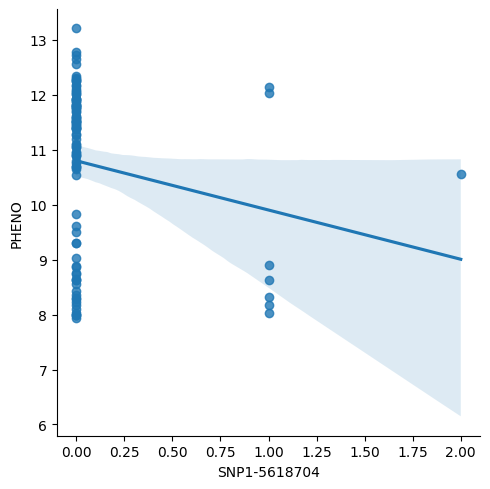

In [ ]:
#seaborn produces beautiful plots that are similar to ggplot in R!
# here is some help: https://seaborn.pydata.org/archive/0.11/tutorial/regression.html
sns.lmplot(x="SNP1-5618704",y="PHENO",data=CEUCon)
#sns.regplot(x="SNP1-5618704",y="PHENO",data=CEUCon)
# --------
# Note that sns.lmplot provides you with a confidence interval for your OLS line
# --------

### Anaylsis Practice

Now, you should replicate this analysis with the Yorubi Population.

In [ ]:
# Now the same thing for Yorubi
# So, now we will see a visualization of the phenotype-genotype association
# Pull out relevant columns: PHENO and SNP1-5618704
# and map the genotypes into doses: AA into 0, AC/CA into 1 and CC into 2 representing the number of C alleles



       PHENO SNP1-5618704
104  10.6536           CA
105  10.3231           AA
106  12.0274           AA
107  11.1634           AA
108  11.8303           AA
~~~~~~~
104    1
105    0
106    0
107    0
108    0
      ..
190    2
191    0
192    1
193    0
194    2
Name: SNP1-5618704, Length: 91, dtype: int64


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


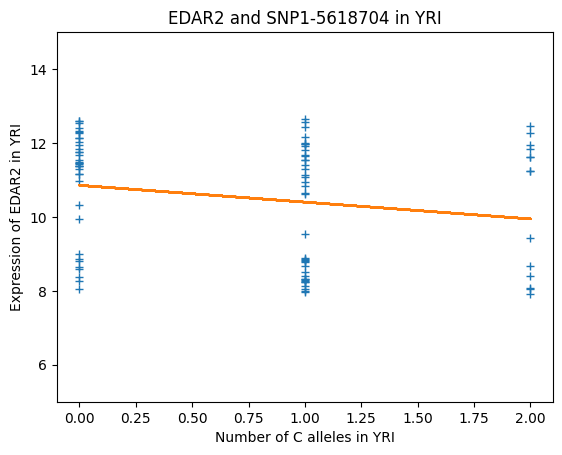

In [ ]:
# simple linear regression: average value of Y =intercept +slope*X
# you need to pull out each column first


In [ ]:
# What is the slope and is it statistically different than 0?
#print("the intercept is: ", m_yri)
#print("the slope is: ", b_yri)
# We would have to use statistics to quantify how different from 0 this is, but it seems unlikely to be different.

the intercept is:  10.854400719844351
the slope is:  -0.4544540515564181


## Ordinary Least Squares

In the above examples, we used one X to predict an outcome Y. You could also use a set of predictors $X_1,X_2,X_3,...,X_i$

OLS is a strategy that places a line of best fit (regression line) that minimizes the scatter of the points around the line. The slope in this case, $\beta$ = ($\beta_0,\beta_1,\beta_2,...,\beta_i$) will minimize the sum of the squares of the differences between the observed $y_i$ values and the predicted $\hat{y_i}$ predicted based on the set of predictors, $x_1, x_2,...,x_i $

In [ ]:
# back to CEU
x=np.array(CEUNumConversion)
y=np.array(CEUCurated["PHENO"])
x = sm.add_constant(x)
result = sm.OLS(y, x).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3.718
Date:                Tue, 06 May 2025   Prob (F-statistic):             0.0566
Time:                        15:20:31   Log-Likelihood:                -187.77
No. Observations:                 104   AIC:                             379.5
Df Residuals:                     102   BIC:                             384.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7997      0.151     71.432      0.0

Other questions that can be asked:
* Are the genotype patterns similar between the YRI and CEU samples?
* What is a good estimate? What is an estimate anyway?!
* Do genotype frequencies (or allele frequencies) differ between the YRI and
CEU populations?
* Statistical inference is needed again!

In [ ]:
# -----------------
# Repeat the analysis above with YRI
#

## False Positivies

When you test a lot of null hypothesese simulataneously, as we are doing with GWAS analysis, you **will get false positives**. To demonstrate what I mean, I used the material from [Dr. Lei Sun at the University of Toronto](https://github.com/LeiSunUofT/How-to-Run-a-GWAS/blob/main/stat-Sun-module4-mht.pdf).

**Strategy**
* we will decouple PHENO and SNP1- by simulating the columns independently from each other. That way we know that **there is no correlation because we have broken up any that might actually exist in our sample**.
* We will still find false positives that have a low p-value... in fact, we expect to find ~50 of them in 1000 runs ($\alpha=0.05$)



In [ ]:
from random import sample

In [ ]:
# remember the PHENO column values
print(CEUCurated["PHENO"])
#permute the observed y values so that we KNOW that there is no correlation between X and Y (because if there
# was initially, we have destroyed it
y_simulated=CEUCurated["PHENO"].sample(len(CEUCurated["PHENO"]))
print("Here are the simulated pheno values")
print(y_simulated)
#bind the columns to create new dataframe
CEU_Simulated=pd.concat([y_simulated,CEUNumConversion],axis=1)
print(CEU_Simulated)

0      11.49810
1      10.67960
2      10.54530
3      11.45550
4       7.98708
         ...   
99     11.91800
100     8.11012
101    12.29190
102    11.55000
103    10.68810
Name: PHENO, Length: 104, dtype: float64
Here are the simulated pheno values
47     11.39110
15     10.70700
74     12.13520
62     10.94570
100     8.11012
         ...   
52      8.86301
76     12.65100
11     12.77880
5      11.26740
26     12.17570
Name: PHENO, Length: 104, dtype: float64
        PHENO  SNP1-5618704
47   11.39110             0
15   10.70700             0
74   12.13520             1
62   10.94570             0
100   8.11012             0
..        ...           ...
52    8.86301             0
76   12.65100             0
11   12.77880             0
5    11.26740             0
26   12.17570             0

[104 rows x 2 columns]


In [ ]:
#sns.lmplot(x="SNP1-5618704",y="PHENO",data=CEU_Simulated)
# back to CEU
x=np.array(CEUNumConversion)
y=np.array(CEU_Simulated["PHENO"])
x = sm.add_constant(x)
result = sm.OLS(y, x).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.758
Date:                Tue, 06 May 2025   Prob (F-statistic):              0.188
Time:                        15:50:14   Log-Likelihood:                -188.74
No. Observations:                 104   AIC:                             381.5
Df Residuals:                     102   BIC:                             386.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6682      0.153     69.906      0.0